#### <center>Предсказание выигрыша/проигрыша команд NBA в играх Конференций в 2019 году (сезон 2018/2019).</center>

In [171]:
import os, glob, math
import random, pickle, re
import gc

import numpy as np
import pandas as pd

pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.width', 80)

from utils_s import preproc_s

from scipy.stats import normaltest, norm
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder

from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization, Dropout
from keras import regularizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam

from sklearn.metrics import (classification_report, roc_curve, f1_score, 
                             confusion_matrix)

from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use(['seaborn-darkgrid'])
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore') 

seed = 7
np.random.seed(seed)

#### Загрузка и подготовка данных<a id="1"></a>

In [2]:
dirpath = 'regular_seasons'
output = 'regular_seasons.csv'

In [3]:
pd.concat(
    pd.read_csv(os.path.join(dirpath, fname), sep="|", index_col=0, header=None)
    for fname in sorted(os.listdir(dirpath))
).to_csv(output)

In [2]:
data = pd.read_csv('regular_seasons.csv')
data.head()

,0,1,2
0,27.10.2010 03:30,Бостон Селтикс – Майами Хит,88 : 80
1,27.10.2010 06:00,Портленд Трэйл Блэйзерс – Финикс Санз,106 : 92
2,27.10.2010 06:30,Лос-Анджелес Лейкерс – Хьюстон Рокетс,112 : 110
3,28.10.2010 03:00,Нью-Джерси Нетс – Детройт Пистонс,101 : 98
4,28.10.2010 03:00,Кливленд Кавальерс – Бостон Селтикс,95 : 87


In [3]:
data['date'] = pd.to_datetime(data['0'], dayfirst=True)

data['year'] = data.date.dt.year
data['month'] = data.date.dt.month

data['host'] = data['1'].apply(lambda x: x.split('–')[0].strip())
data['visitor'] = data['1'].apply(lambda x: x.split('–')[1].strip())

data['host_score'] = data['2'].apply(lambda x: int(x.split(':')[0].strip()))

data['visitor_score_OT'] = data['2'].apply(lambda x: x.split(':')[1].strip())

data['visitor_score'] = data['visitor_score_OT'].apply(
    lambda x: int(x.split(' ')[0].strip()))

del data['0'], data['1'], data['2'], data['visitor_score_OT'], data['date'] 

In [4]:
data.head()

,year,month,host,visitor,host_score,visitor_score
0,2010,10,Бостон Селтикс,Майами Хит,88,80
1,2010,10,Портленд Трэйл Блэйзерс,Финикс Санз,106,92
2,2010,10,Лос-Анджелес Лейкерс,Хьюстон Рокетс,112,110
3,2010,10,Нью-Джерси Нетс,Детройт Пистонс,101,98
4,2010,10,Кливленд Кавальерс,Бостон Селтикс,95,87


In [5]:
data['host'].value_counts()

Даллас Маверикс            361
Мемфис Гриззлиз            361
Кливленд Кавальерс         361
Голден Стэйт Уорриорз      361
Оклахома-Сити Тандер       361
Филадельфия Сиксерс        361
Нью-Йорк Никс              361
Лос-Анджелес Клипперс      361
Милуоки Бакс               361
Сан-Антонио Спёрс          361
Хьюстон Рокетс             361
Портленд Трэйл Блэйзерс    361
Детройт Пистонс            361
Торонто Рэпторс            361
Лос-Анджелес Лейкерс       361
Сакраменто Кингз           361
Юта Джаз                   361
Вашингтон Уизардс          361
Миннесота Тимбервулвз      361
Атланта Хоукс              361
Чикаго Буллз               361
Орландо Мэджик             361
Финикс Санз                361
Майами Хит                 361
Денвер Наггетс             361
Индиана Пэйсерс            361
Бостон Селтикс             360
Бруклин Нетс               287
Нью-Орлеан Пеликанс        246
Шарлотт Хорнетс            205
Шарлотт Бобкэтс            156
Нью-Орлеан Хорнетс         115
Нью-Джер

Исследуем причины существенной разницы в количестве игр для нескольких команд.

In [6]:
check_names = data['host'].value_counts().sort_index()
check_names.index[check_names.values < 361]

check_vis = data['visitor'].value_counts().sort_index()
check_vis.index[check_vis.values < 361]

Index(['Бостон Селтикс', 'Бруклин Нетс', 'Нью-Джерси Нетс',
       'Нью-Орлеан Пеликанс', 'Нью-Орлеан Хорнетс', 'Шарлотт Бобкэтс',
       'Шарлотт Хорнетс'],
      dtype='object')

Index(['Бруклин Нетс', 'Индиана Пэйсерс', 'Нью-Джерси Нетс',
       'Нью-Орлеан Пеликанс', 'Нью-Орлеан Хорнетс', 'Шарлотт Бобкэтс',
       'Шарлотт Хорнетс'],
      dtype='object')

#### Изменение названий команд

***Бруклин Нетс***

"13 апреля 2012 года Совет генеральных менеджеров НБА одобрил переезд «Нью-Джерси Нетс» на новую арену «Барклайс-центр», располагающуюся в Бруклине, Нью-Йорк. В связи с переездом в Нью-Йорк клуб сменил своё название на «Бруклин Нетс»." __[Источник](https://en.wikipedia.org/wiki/Brooklyn_Nets)__


***Нью-Орлеан Пеликанс***

"До сезона 2013/2014 команда сохраняла название «Хорнетс». 18 апреля 2013 года, название команды было официально изменено на «Пеликанс». Администрация НБА заявила, что наименование «Хорнетс» может быть использовано Шарлотт, но сменить название будет возможно не ранее сезона 2014—2015 годов." __[Источник](https://en.wikipedia.org/wiki/New_Orleans_Pelicans)__


***Шарлотт Хорнетс***

"Команда переименована в «Шарлотт Хорнетс» с сезона 2014/15, после того как команда Нового Орлеана в 2013 году отказалась от имени «Хорнетс»." __[Источник](https://en.wikipedia.org/wiki/Charlotte_Hornets)__

In [5]:
data['host'] = data['host'].apply(
    lambda x: re.sub('Нью-Джерси Нетс', 'Бруклин Нетс', x))
data['host'] = data['host'].apply(
    lambda x: re.sub('Нью-Орлеан Хорнетс', 'Нью-Орлеан Пеликанс', x))
data['host'] = data['host'].apply(
    lambda x: re.sub('Шарлотт Бобкэтс', 'Шарлотт Хорнетс', x))

data['visitor'] = data['visitor'].apply(
    lambda x: re.sub('Нью-Джерси Нетс', 'Бруклин Нетс', x))
data['visitor'] = data['visitor'].apply(
    lambda x: re.sub('Нью-Орлеан Хорнетс', 'Нью-Орлеан Пеликанс', x))
data['visitor'] = data['visitor'].apply(
    lambda x: re.sub('Шарлотт Бобкэтс', 'Шарлотт Хорнетс', x))

In [8]:
check_vis = data['visitor'].value_counts().sort_index()
check_names = data['host'].value_counts().sort_index()

check_names.index[check_names.values < 361]
check_vis.index[check_vis.values < 361]

Index(['Бостон Селтикс'], dtype='object')

Index(['Индиана Пэйсерс'], dtype='object')

Отсутствует информация об игре `'Бостон Селтикс'-'Индиана Пэйсерс'`. 

In [6]:
gc.collect()

82

In [7]:
data

,year,month,host,visitor,host_score,visitor_score
0,2010,10,Бостон Селтикс,Майами Хит,88,80
1,2010,10,Портленд Трэйл Блэйзерс,Финикс Санз,106,92
2,2010,10,Лос-Анджелес Лейкерс,Хьюстон Рокетс,112,110
3,2010,10,Бруклин Нетс,Детройт Пистонс,101,98
4,2010,10,Кливленд Кавальерс,Бостон Селтикс,95,87
...,...,...,...,...,...,...
10824,2019,4,Бруклин Нетс,Майами Хит,113,94
10825,2019,4,Атланта Хоукс,Индиана Пэйсерс,134,135
10826,2019,4,Портленд Трэйл Блэйзерс,Сакраменто Кингз,136,131
10827,2019,4,Лос-Анджелес Клипперс,Юта Джаз,143,137


**Target**

In [8]:
data['home_win'] = np.where(
    (data.host_score - data.visitor_score) > 0, 1, 0)
data['visitor_win'] = np.where(
    (data.host_score - data.visitor_score) < 0, 1, 0)

In [9]:
data['home_win'].value_counts()

1    6379
0    4450
Name: home_win, dtype: int64

In [10]:
# Процент выигрышей, если команда играет дома
round(6379/(6379+4450)*100, 2)

58.91

**Выделение обучающего и тестового наборов.**

In [11]:
train_df = data[data.year < 2019]
test_df = data[data.year == 2019]

In [12]:
del (test_df['year'], test_df['month'], test_df['host_score'], 
     test_df['visitor_score'], test_df['visitor_win'])

In [13]:
test_df

,host,visitor,home_win
10141,Шарлотт Хорнетс,Орландо Мэджик,1
10142,Сан-Антонио Спёрс,Бостон Селтикс,1
10143,Хьюстон Рокетс,Мемфис Гриззлиз,1
10144,Оклахома-Сити Тандер,Даллас Маверикс,1
10145,Нью-Орлеан Пеликанс,Миннесота Тимбервулвз,1
...,...,...,...
10824,Бруклин Нетс,Майами Хит,1
10825,Атланта Хоукс,Индиана Пэйсерс,0
10826,Портленд Трэйл Блэйзерс,Сакраменто Кингз,1
10827,Лос-Анджелес Клипперс,Юта Джаз,1


In [14]:
gc.collect()

20

#### EDA

**Количество игр**

In [15]:
train_df.head()

,year,month,host,visitor,host_score,visitor_score,home_win,visitor_win
0,2010,10,Бостон Селтикс,Майами Хит,88,80,1,0
1,2010,10,Портленд Трэйл Блэйзерс,Финикс Санз,106,92,1,0
2,2010,10,Лос-Анджелес Лейкерс,Хьюстон Рокетс,112,110,1,0
3,2010,10,Бруклин Нетс,Детройт Пистонс,101,98,1,0
4,2010,10,Кливленд Кавальерс,Бостон Селтикс,95,87,1,0


In [16]:
train_df.groupby(['year', 'host'])['host'].transform('count').unique()
train_df.groupby(['year', 'visitor'])['visitor'].transform('count').unique()

array([15, 14, 16, 17, 18, 19, 20, 28, 25, 29, 30, 27, 23, 26, 46, 48, 49,
       45, 44, 47, 42, 50, 43, 38, 41, 39, 40, 37, 36], dtype=int64)

array([17, 16, 15, 11, 14, 19, 18, 12, 28, 25, 27, 26, 23, 31, 30, 22, 24,
       29, 53, 50, 44, 47, 45, 42, 46, 49, 43, 41, 48, 40, 39, 37, 36, 35,
       38, 34, 33], dtype=int64)

In [17]:
train_df['num_hostGames_perYear'] = (
    train_df.groupby(['year', 'host'])['host'].transform('count'))
train_df['num_visitorGames_perYear'] = (
    train_df.groupby(['year', 'visitor'])['visitor'].transform('count'))

In [18]:
train_df.head()

,year,month,host,visitor,host_score,visitor_score,home_win,visitor_win,num_hostGames_perYear,num_visitorGames_perYear
0,2010,10,Бостон Селтикс,Майами Хит,88,80,1,0,15,17
1,2010,10,Портленд Трэйл Блэйзерс,Финикс Санз,106,92,1,0,14,16
2,2010,10,Лос-Анджелес Лейкерс,Хьюстон Рокетс,112,110,1,0,14,17
3,2010,10,Бруклин Нетс,Детройт Пистонс,101,98,1,0,15,16
4,2010,10,Кливленд Кавальерс,Бостон Селтикс,95,87,1,0,15,16


**Количество выигрышей команд по годам**

In [19]:
train_df['num_hostWins_perYear'] = train_df.groupby(
    ['year', 'host'])['home_win'].transform('sum')

train_df['num_visitorWins_perYear'] = train_df.groupby(
    ['year', 'visitor'])['visitor_win'].transform('sum')

In [20]:
train_df.head()

,year,month,host,visitor,host_score,visitor_score,home_win,visitor_win,num_hostGames_perYear,num_visitorGames_perYear,num_hostWins_perYear,num_visitorWins_perYear
0,2010,10,Бостон Селтикс,Майами Хит,88,80,1,0,15,17,13,12
1,2010,10,Портленд Трэйл Блэйзерс,Финикс Санз,106,92,1,0,14,16,11,6
2,2010,10,Лос-Анджелес Лейкерс,Хьюстон Рокетс,112,110,1,0,14,17,10,6
3,2010,10,Бруклин Нетс,Детройт Пистонс,101,98,1,0,15,16,6,3
4,2010,10,Кливленд Кавальерс,Бостон Селтикс,95,87,1,0,15,16,5,11


**Разница в счете**

In [21]:
train_df['differ'] = train_df.host_score - train_df.visitor_score

In [22]:
train_df['differ'].value_counts()

 7     418
 5     390
 8     354
 6     336
 3     334
      ... 
-56      1
-51      1
 53      1
 61      1
-45      1
Name: differ, Length: 98, dtype: int64

In [23]:
print(sorted(list(train_df['differ'].value_counts().index)))

[-56, -51, -48, -45, -41, -40, -39, -38, -37, -36, -35, -34, -33, -32, -31, -30, -29, -28, -27, -26, -25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 53, 55, 61]


In [24]:
# Биннинг 'differ'
train_df['diff_range'] = pd.cut(
    train_df['differ'],
    bins=[-np.inf, -28, -16, 20, 32, np.inf],
    labels=[
        'super_neg_diff', 'large_neg_diff', 'middle', 'large_pos_diff',
        'super_pos_diff'
    ])

In [25]:
train_df['diff_range'].value_counts()

middle            8420
large_neg_diff     719
large_pos_diff     716
super_pos_diff     154
super_neg_diff     132
Name: diff_range, dtype: int64

In [26]:
del train_df['differ']

In [27]:
train_df_cat = pd.get_dummies(train_df.diff_range)

In [28]:
train = pd.concat((train_df, train_df_cat), axis=1)
del train['diff_range'], train['middle']

In [29]:
train.head(3)
train.tail(3)

,year,month,host,visitor,host_score,visitor_score,home_win,visitor_win,num_hostGames_perYear,num_visitorGames_perYear,num_hostWins_perYear,num_visitorWins_perYear,super_neg_diff,large_neg_diff,large_pos_diff,super_pos_diff
0,2010,10,Бостон Селтикс,Майами Хит,88,80,1,0,15,17,13,12,0,0,0,0
1,2010,10,Портленд Трэйл Блэйзерс,Финикс Санз,106,92,1,0,14,16,11,6,0,0,0,0
2,2010,10,Лос-Анджелес Лейкерс,Хьюстон Рокетс,112,110,1,0,14,17,10,6,0,0,0,0


,year,month,host,visitor,host_score,visitor_score,home_win,visitor_win,num_hostGames_perYear,num_visitorGames_perYear,num_hostWins_perYear,num_visitorWins_perYear,super_neg_diff,large_neg_diff,large_pos_diff,super_pos_diff
10138,2018,12,Портленд Трэйл Блэйзерс,Филадельфия Сиксерс,129,95,1,0,43,40,34,20,0,0,0,1
10139,2018,12,Лос-Анджелес Лейкерс,Сакраменто Кингз,121,114,1,0,42,40,27,16,0,0,0,0
10140,2018,12,Индиана Пэйсерс,Атланта Хоукс,116,108,1,0,41,43,30,10,0,0,0,0


In [30]:
train['num_super_negDiff'] = train.groupby(
    ['year', 'host', 'super_neg_diff'])['super_neg_diff'].transform('sum')
train['num_super_posDiff'] = train.groupby(
    ['year', 'host', 'super_pos_diff'])['super_pos_diff'].transform('sum')

train['num_large_negDiff'] = train.groupby(
    ['year', 'host', 'large_neg_diff'])['large_neg_diff'].transform('sum')
train['num_large_posDiff'] = train.groupby(
    ['year', 'host', 'large_pos_diff'])['large_pos_diff'].transform('sum')

In [31]:
train.tail(3)

,year,month,host,visitor,host_score,visitor_score,home_win,visitor_win,num_hostGames_perYear,num_visitorGames_perYear,num_hostWins_perYear,num_visitorWins_perYear,super_neg_diff,large_neg_diff,large_pos_diff,super_pos_diff,num_super_negDiff,num_super_posDiff,num_large_negDiff,num_large_posDiff
10138,2018,12,Портленд Трэйл Блэйзерс,Филадельфия Сиксерс,129,95,1,0,43,40,34,20,0,0,0,1,0,1,0,0
10139,2018,12,Лос-Анджелес Лейкерс,Сакраменто Кингз,121,114,1,0,42,40,27,16,0,0,0,0,0,0,0,0
10140,2018,12,Индиана Пэйсерс,Атланта Хоукс,116,108,1,0,41,43,30,10,0,0,0,0,0,0,0,0


In [32]:
del (train['super_neg_diff'], train['large_neg_diff'], 
     train['large_pos_diff'], train['super_pos_diff'])

Какую часть от общего числа игр команды в году составляют игры с большим отрывом в счете:

In [33]:
train['superPosDiff_ratio_perYear'] =  train[
    'num_super_posDiff'] / train['num_hostGames_perYear']
train['largePosDiff_ratio_perYear'] = train[
    'num_large_posDiff'] / train['num_hostGames_perYear']

train['superNegDiff_ratio_perYear'] = train[
    'num_super_negDiff'] / train['num_visitorGames_perYear']
train['largeNegDiff_ratio_perYear'] = train[
    'num_large_negDiff'] / train['num_visitorGames_perYear']

In [34]:
del (train['num_super_negDiff'], train['num_super_posDiff'], 
     train['num_large_negDiff'], train['num_large_posDiff'])

In [35]:
train.tail(3)

,year,month,host,visitor,host_score,visitor_score,home_win,visitor_win,num_hostGames_perYear,num_visitorGames_perYear,num_hostWins_perYear,num_visitorWins_perYear,superPosDiff_ratio_perYear,largePosDiff_ratio_perYear,superNegDiff_ratio_perYear,largeNegDiff_ratio_perYear
10138,2018,12,Портленд Трэйл Блэйзерс,Филадельфия Сиксерс,129,95,1,0,43,40,34,20,0.023256,0.0,0.0,0.0
10139,2018,12,Лос-Анджелес Лейкерс,Сакраменто Кингз,121,114,1,0,42,40,27,16,0.000000,0.0,0.0,0.0
10140,2018,12,Индиана Пэйсерс,Атланта Хоукс,116,108,1,0,41,43,30,10,0.000000,0.0,0.0,0.0


### Рейтинги

**Рейтинг по победам**

In [36]:
train['host_winRatio_perYear'] = train[
    'num_hostWins_perYear'] / train['num_hostGames_perYear']
train['visitor_winRatio_perYear'] = train[
    'num_visitorWins_perYear'] / train['num_visitorGames_perYear']

In [37]:
del (train['host_score'], train['visitor_score'], train['visitor_win'], 
     train['num_hostWins_perYear'], train['num_visitorWins_perYear'])

In [38]:
train.head()

,year,month,host,visitor,home_win,num_hostGames_perYear,num_visitorGames_perYear,superPosDiff_ratio_perYear,largePosDiff_ratio_perYear,superNegDiff_ratio_perYear,largeNegDiff_ratio_perYear,host_winRatio_perYear,visitor_winRatio_perYear
0,2010,10,Бостон Селтикс,Майами Хит,1,15,17,0.0,0.0,0.0,0.0,0.866667,0.705882
1,2010,10,Портленд Трэйл Блэйзерс,Финикс Санз,1,14,16,0.0,0.0,0.0,0.0,0.785714,0.375000
2,2010,10,Лос-Анджелес Лейкерс,Хьюстон Рокетс,1,14,17,0.0,0.0,0.0,0.0,0.714286,0.352941
3,2010,10,Бруклин Нетс,Детройт Пистонс,1,15,16,0.0,0.0,0.0,0.0,0.400000,0.187500
4,2010,10,Кливленд Кавальерс,Бостон Селтикс,1,15,16,0.0,0.0,0.0,0.0,0.333333,0.687500


**Дополнение к рейтингу - игры с большой разницей в счете**

In [39]:
# При большой положительной разнице увеличиваем рейтинг хозяевам
train[
    'host_diffRatio_perYear'] = train.largePosDiff_ratio_perYear + train.superPosDiff_ratio_perYear

# При большой отрицательной разнице увеличиваем рейтинг гостям
train[
    'visitor_diffRatio_perYear'] = train.largeNegDiff_ratio_perYear + train.superNegDiff_ratio_perYear

In [40]:
train.tail(3)

,year,month,host,visitor,home_win,num_hostGames_perYear,num_visitorGames_perYear,superPosDiff_ratio_perYear,largePosDiff_ratio_perYear,superNegDiff_ratio_perYear,largeNegDiff_ratio_perYear,host_winRatio_perYear,visitor_winRatio_perYear,host_diffRatio_perYear,visitor_diffRatio_perYear
10138,2018,12,Портленд Трэйл Блэйзерс,Филадельфия Сиксерс,1,43,40,0.023256,0.0,0.0,0.0,0.790698,0.500000,0.023256,0.0
10139,2018,12,Лос-Анджелес Лейкерс,Сакраменто Кингз,1,42,40,0.000000,0.0,0.0,0.0,0.642857,0.400000,0.000000,0.0
10140,2018,12,Индиана Пэйсерс,Атланта Хоукс,1,41,43,0.000000,0.0,0.0,0.0,0.731707,0.232558,0.000000,0.0


In [41]:
del (train['num_hostGames_perYear'], train['num_visitorGames_perYear'],
     train['superPosDiff_ratio_perYear'], train['superNegDiff_ratio_perYear'],
     train['largePosDiff_ratio_perYear'], train['largeNegDiff_ratio_perYear'])

**Общий рейтинг**

In [42]:
train['host_ratio_perYear'] = (train.host_diffRatio_perYear +
                               train.host_winRatio_perYear)
train['visitor_ratio_perYear'] = (train.visitor_diffRatio_perYear +
                                  train.visitor_winRatio_perYear)

In [43]:
del (train['host_diffRatio_perYear'], train['host_winRatio_perYear'],
     train['visitor_diffRatio_perYear'], train['visitor_winRatio_perYear'])

In [44]:
train.head(8)

,year,month,host,visitor,home_win,host_ratio_perYear,visitor_ratio_perYear
0,2010,10,Бостон Селтикс,Майами Хит,1,0.866667,0.705882
1,2010,10,Портленд Трэйл Блэйзерс,Финикс Санз,1,0.785714,0.375000
2,2010,10,Лос-Анджелес Лейкерс,Хьюстон Рокетс,1,0.714286,0.352941
3,2010,10,Бруклин Нетс,Детройт Пистонс,1,0.400000,0.187500
4,2010,10,Кливленд Кавальерс,Бостон Селтикс,1,0.333333,0.687500
5,2010,10,Филадельфия Сиксерс,Майами Хит,0,0.571429,0.705882
6,2010,10,Торонто Рэпторс,Нью-Йорк Никс,0,0.437500,0.588235
7,2010,10,Нью-Орлеан Пеликанс,Милуоки Бакс,1,0.764706,0.312500


In [45]:
# Прибавляли рейтинг по разнице в счете, усредняем значения в годах
train['host_ratio_perYear'] = train.groupby(
    ['year', 'host'])['host_ratio_perYear'].transform('mean')
train['visitor_ratio_perYear'] = train.groupby(
    ['year', 'visitor'])['visitor_ratio_perYear'].transform('mean')

In [46]:
train['host_ratio_perYear'] = (
    train['host_ratio_perYear'].apply(lambda x: round(x, 5)))
train['visitor_ratio_perYear'] = (
    train['visitor_ratio_perYear'].apply(lambda x: round(x, 5)))

In [75]:
train

,year,month,host,visitor,home_win,host_ratio_perYear,visitor_ratio_perYear
0,2010,10,Бостон Селтикс,Майами Хит,1,0.87111,0.74394
1,2010,10,Портленд Трэйл Блэйзерс,Финикс Санз,1,0.80612,0.37891
2,2010,10,Лос-Анджелес Лейкерс,Хьюстон Рокетс,1,0.76531,0.35640
3,2010,10,Бруклин Нетс,Детройт Пистонс,1,0.40000,0.20312
4,2010,10,Кливленд Кавальерс,Бостон Селтикс,1,0.33333,0.72266
...,...,...,...,...,...,...,...
10136,2018,12,Майами Хит,Миннесота Тимбервулвз,0,0.62412,0.30280
10137,2018,12,Даллас Маверикс,Оклахома-Сити Тандер,1,0.55500,0.60519
10138,2018,12,Портленд Трэйл Блэйзерс,Филадельфия Сиксерс,1,0.79989,0.51375
10139,2018,12,Лос-Анджелес Лейкерс,Сакраменто Кингз,1,0.64796,0.41750


In [48]:
train_copy = train.copy(deep=True)

#### Тестовая выборка

В тестовую выборку нужно добавить значения рейтингов. Будем использовать среднее от суммы значений рейтингов 2018 года и первой части сезона 2018/2019.

Получение значений рейтингов за сезон 2018/2019 аналогично предыдущей обработке всей обучающей выборки, только вместо года берется сезон. Используется функция `preproc_s` из вспомогательного модуля `utils_s.py`.

In [65]:
train_part = data.loc[(data.month > 6) & (data.year == 2018)]

In [66]:
train_part

,year,month,host,visitor,host_score,visitor_score,home_win,visitor_win
9599,2018,10,Бостон Селтикс,Филадельфия Сиксерс,105,87,1,0
9600,2018,10,Голден Стэйт Уорриорз,Оклахома-Сити Тандер,108,100,1,0
9601,2018,10,Орландо Мэджик,Майами Хит,104,101,1,0
9602,2018,10,Индиана Пэйсерс,Мемфис Гриззлиз,111,83,1,0
9603,2018,10,Детройт Пистонс,Бруклин Нетс,103,100,1,0
...,...,...,...,...,...,...,...,...
10136,2018,12,Майами Хит,Миннесота Тимбервулвз,104,113,0,1
10137,2018,12,Даллас Маверикс,Оклахома-Сити Тандер,105,103,1,0
10138,2018,12,Портленд Трэйл Блэйзерс,Филадельфия Сиксерс,129,95,1,0
10139,2018,12,Лос-Анджелес Лейкерс,Сакраменто Кингз,121,114,1,0


In [67]:
train_9 = preproc_s(train_part)
train_9

,host,visitor,home_win,host_ratio_season9,visitor_ratio_season9
9599,Бостон Селтикс,Филадельфия Сиксерс,1,0.72656,0.41358
9600,Голден Стэйт Уорриорз,Оклахома-Сити Тандер,1,0.76000,0.55679
9601,Орландо Мэджик,Майами Хит,1,0.47846,0.60156
9602,Индиана Пэйсерс,Мемфис Гриззлиз,1,0.75069,0.44444
9603,Детройт Пистонс,Бруклин Нетс,1,0.57895,0.48148
...,...,...,...,...,...
10136,Майами Хит,Миннесота Тимбервулвз,0,0.43213,0.28704
10137,Даллас Маверикс,Оклахома-Сити Тандер,1,0.83951,0.55679
10138,Портленд Трэйл Блэйзерс,Филадельфия Сиксерс,1,0.71250,0.41358
10139,Лос-Анджелес Лейкерс,Сакраменто Кингз,1,0.68698,0.51801


In [68]:
host_ratio_9 = train_9.host_ratio_season9.groupby(train_9.host).first().to_frame()
host_ratio_9['host'] = host_ratio_9.index
host_ratio_9.shape
host_ratio_9.head()

(30, 2)

,host_ratio_season9,host
host,,
Атланта Хоукс,0.37500,Атланта Хоукс
Бостон Селтикс,0.72656,Бостон Селтикс
Бруклин Нетс,0.45250,Бруклин Нетс
Вашингтон Уизардс,0.59170,Вашингтон Уизардс
Голден Стэйт Уорриорз,0.76000,Голден Стэйт Уорриорз


Создаем словарь значений рейтинга.

In [69]:
host_ratio_dict9 = dict(zip(host_ratio_9.host, host_ratio_9.host_ratio_season9))

In [70]:
print(host_ratio_dict9)

{'Атланта Хоукс': 0.375, 'Бостон Селтикс': 0.72656, 'Бруклин Нетс': 0.4525, 'Вашингтон Уизардс': 0.5917, 'Голден Стэйт Уорриорз': 0.76, 'Даллас Маверикс': 0.83951, 'Денвер Наггетс': 0.85813, 'Детройт Пистонс': 0.57895, 'Индиана Пэйсерс': 0.75069, 'Кливленд Кавальерс': 0.29012, 'Лос-Анджелес Клипперс': 0.71972, 'Лос-Анджелес Лейкерс': 0.68698, 'Майами Хит': 0.43213, 'Мемфис Гриззлиз': 0.5917, 'Милуоки Бакс': 0.86427, 'Миннесота Тимбервулвз': 0.67284, 'Нью-Йорк Никс': 0.25, 'Нью-Орлеан Пеликанс': 0.67901, 'Оклахома-Сити Тандер': 0.76562, 'Орландо Мэджик': 0.47846, 'Портленд Трэйл Блэйзерс': 0.7125, 'Сакраменто Кингз': 0.58824, 'Сан-Антонио Спёрс': 0.76454, 'Торонто Рэпторс': 0.78086, 'Филадельфия Сиксерс': 0.91136, 'Финикс Санз': 0.28086, 'Хьюстон Рокетс': 0.70934, 'Чикаго Буллз': 0.27778, 'Шарлотт Хорнетс': 0.66, 'Юта Джаз': 0.56641}


In [71]:
test_df['host_ratio_season9'] = test_df['host'].map(host_ratio_dict9)

In [72]:
visitor_ratio_9 = train_9.visitor_ratio_season9.groupby(train_9.visitor).first().to_frame()
visitor_ratio_9['visitor'] = visitor_ratio_9.index
visitor_ratio_dict9 = dict(zip(visitor_ratio_9.visitor, visitor_ratio_9.visitor_ratio_season9))
print(visitor_ratio_dict9)

{'Атланта Хоукс': 0.2675, 'Бостон Селтикс': 0.55125, 'Бруклин Нетс': 0.48148, 'Вашингтон Уизардс': 0.2, 'Голден Стэйт Уорриорз': 0.57785, 'Даллас Маверикс': 0.13149, 'Денвер Наггетс': 0.55363, 'Детройт Пистонс': 0.33333, 'Индиана Пэйсерс': 0.62654, 'Кливленд Кавальерс': 0.15789, 'Лос-Анджелес Клипперс': 0.49307, 'Лос-Анджелес Лейкерс': 0.4784, 'Майами Хит': 0.60156, 'Мемфис Гриззлиз': 0.44444, 'Милуоки Бакс': 0.57812, 'Миннесота Тимбервулвз': 0.28704, 'Нью-Йорк Никс': 0.2381, 'Нью-Орлеан Пеликанс': 0.22438, 'Оклахома-Сити Тандер': 0.55679, 'Орландо Мэджик': 0.43878, 'Портленд Трэйл Блэйзерс': 0.42561, 'Сакраменто Кингз': 0.51801, 'Сан-Антонио Спёрс': 0.34259, 'Торонто Рэпторс': 0.675, 'Филадельфия Сиксерс': 0.41358, 'Финикс Санз': 0.21607, 'Хьюстон Рокетс': 0.44753, 'Чикаго Буллз': 0.28255, 'Шарлотт Хорнетс': 0.27556, 'Юта Джаз': 0.48753}


In [73]:
test_df['visitor_ratio_season9'] = test_df['visitor'].map(visitor_ratio_dict9)

In [74]:
test_df.head()

,host,visitor,home_win,visitor_ratio_season9,host_ratio_season9
10141,Шарлотт Хорнетс,Орландо Мэджик,1,0.43878,0.66000
10142,Сан-Антонио Спёрс,Бостон Селтикс,1,0.55125,0.76454
10143,Хьюстон Рокетс,Мемфис Гриззлиз,1,0.44444,0.70934
10144,Оклахома-Сити Тандер,Даллас Маверикс,1,0.13149,0.76562
10145,Нью-Орлеан Пеликанс,Миннесота Тимбервулвз,1,0.28704,0.67901


In [76]:
# Выделение данных за 2018 год
train_18 = train[train.year==2018]

In [77]:
train_18

,year,month,host,visitor,home_win,host_ratio_perYear,visitor_ratio_perYear
8906,2018,1,Индиана Пэйсерс,Миннесота Тимбервулвз,0,0.74360,0.30280
8907,2018,1,Бостон Селтикс,Бруклин Нетс,1,0.64061,0.38132
8908,2018,1,Хьюстон Рокетс,Лос-Анджелес Лейкерс,1,0.83500,0.43862
8909,2018,1,Оклахома-Сити Тандер,Даллас Маверикс,0,0.66898,0.17750
8910,2018,1,Лос-Анджелес Клипперс,Шарлотт Хорнетс,1,0.61330,0.40155
...,...,...,...,...,...,...,...
10136,2018,12,Майами Хит,Миннесота Тимбервулвз,0,0.62412,0.30280
10137,2018,12,Даллас Маверикс,Оклахома-Сити Тандер,1,0.55500,0.60519
10138,2018,12,Портленд Трэйл Блэйзерс,Филадельфия Сиксерс,1,0.79989,0.51375
10139,2018,12,Лос-Анджелес Лейкерс,Сакраменто Кингз,1,0.64796,0.41750


In [80]:
host_ratio_18 = train_18.host_ratio_perYear.groupby(train_18.host).first().to_frame()
host_ratio_18['host'] = host_ratio_18.index
host_ratio_18.shape
host_ratio_18.head()

(30, 2)

,host_ratio_perYear,host
host,,
Атланта Хоукс,0.38527,Атланта Хоукс
Бостон Селтикс,0.64061,Бостон Селтикс
Бруклин Нетс,0.38688,Бруклин Нетс
Вашингтон Уизардс,0.52562,Вашингтон Уизардс
Голден Стэйт Уорриорз,0.71327,Голден Стэйт Уорриорз


In [81]:
host_ratio_dict18 = dict(zip(host_ratio_18.host, host_ratio_18.host_ratio_perYear))
print(host_ratio_dict18)

{'Атланта Хоукс': 0.38527, 'Бостон Селтикс': 0.64061, 'Бруклин Нетс': 0.38688, 'Вашингтон Уизардс': 0.52562, 'Голден Стэйт Уорриорз': 0.71327, 'Даллас Маверикс': 0.555, 'Денвер Наггетс': 0.80045, 'Детройт Пистонс': 0.5603, 'Индиана Пэйсерс': 0.7436, 'Кливленд Кавальерс': 0.49732, 'Лос-Анджелес Клипперс': 0.6133, 'Лос-Анджелес Лейкерс': 0.64796, 'Майами Хит': 0.62412, 'Мемфис Гриззлиз': 0.48784, 'Милуоки Бакс': 0.70181, 'Миннесота Тимбервулвз': 0.73468, 'Нью-Йорк Никс': 0.22531, 'Нью-Орлеан Пеликанс': 0.67341, 'Оклахома-Сити Тандер': 0.66898, 'Орландо Мэджик': 0.44642, 'Портленд Трэйл Блэйзерс': 0.79989, 'Сакраменто Кингз': 0.4186, 'Сан-Антонио Спёрс': 0.7436, 'Торонто Рэпторс': 0.78617, 'Филадельфия Сиксерс': 0.91374, 'Финикс Санз': 0.22562, 'Хьюстон Рокетс': 0.835, 'Чикаго Буллз': 0.30952, 'Шарлотт Хорнетс': 0.59131, 'Юта Джаз': 0.65235}


In [82]:
test_df['host_ratio_18'] = test_df['host'].map(host_ratio_dict18)

In [83]:
visitor_ratio_18 = train_18.visitor_ratio_perYear.groupby(train_18.visitor).first().to_frame()
visitor_ratio_18['visitor'] = visitor_ratio_18.index
visitor_ratio_dict18 = dict(zip(visitor_ratio_18.visitor, visitor_ratio_18.visitor_ratio_perYear))
print(visitor_ratio_dict18)

{'Атланта Хоукс': 0.23743, 'Бостон Селтикс': 0.59964, 'Бруклин Нетс': 0.38132, 'Вашингтон Уизардс': 0.36735, 'Голден Стэйт Уорриорз': 0.61273, 'Даллас Маверикс': 0.1775, 'Денвер Наггетс': 0.45983, 'Детройт Пистонс': 0.30748, 'Индиана Пэйсерс': 0.58333, 'Кливленд Кавальерс': 0.34751, 'Лос-Анджелес Клипперс': 0.5461, 'Лос-Анджелес Лейкерс': 0.43862, 'Майами Хит': 0.43767, 'Мемфис Гриззлиз': 0.24263, 'Милуоки Бакс': 0.51933, 'Миннесота Тимбервулвз': 0.3028, 'Нью-Йорк Никс': 0.26075, 'Нью-Орлеан Пеликанс': 0.46372, 'Оклахома-Сити Тандер': 0.60519, 'Орландо Мэджик': 0.26367, 'Портленд Трэйл Блэйзерс': 0.44735, 'Сакраменто Кингз': 0.4175, 'Сан-Антонио Спёрс': 0.30637, 'Торонто Рэпторс': 0.67876, 'Филадельфия Сиксерс': 0.51375, 'Финикс Санз': 0.17063, 'Хьюстон Рокетс': 0.64143, 'Чикаго Буллз': 0.27781, 'Шарлотт Хорнетс': 0.40155, 'Юта Джаз': 0.63636}


In [84]:
test_df['visitor_ratio_18'] = test_df['visitor'].map(visitor_ratio_dict18)

In [85]:
test_df.head()

,host,visitor,home_win,visitor_ratio_season9,host_ratio_season9,host_ratio_18,visitor_ratio_18
10141,Шарлотт Хорнетс,Орландо Мэджик,1,0.43878,0.66000,0.59131,0.26367
10142,Сан-Антонио Спёрс,Бостон Селтикс,1,0.55125,0.76454,0.74360,0.59964
10143,Хьюстон Рокетс,Мемфис Гриззлиз,1,0.44444,0.70934,0.83500,0.24263
10144,Оклахома-Сити Тандер,Даллас Маверикс,1,0.13149,0.76562,0.66898,0.17750
10145,Нью-Орлеан Пеликанс,Миннесота Тимбервулвз,1,0.28704,0.67901,0.67341,0.30280


In [86]:
test_df['host_ratio_perYear'] = ((test_df['host_ratio_18'] + 
                                   test_df['host_ratio_season9']) * .5)
test_df['visitor_ratio_perYear'] = ((test_df['visitor_ratio_18'] + 
                                      test_df['visitor_ratio_season9']) * .5)

In [87]:
test_df['host_ratio_perYear'] = test_df['host_ratio_perYear'].apply(lambda x: round(x, 5))
test_df['visitor_ratio_perYear'] = test_df['visitor_ratio_perYear'].apply(lambda x: round(x, 5))

In [88]:
del (test_df['host_ratio_18'], test_df['visitor_ratio_18'],
    test_df['host_ratio_season9'], test_df['visitor_ratio_season9'])

In [89]:
test_df.head()

,host,visitor,home_win,host_ratio_perYear,visitor_ratio_perYear
10141,Шарлотт Хорнетс,Орландо Мэджик,1,0.62566,0.35123
10142,Сан-Антонио Спёрс,Бостон Селтикс,1,0.75407,0.57544
10143,Хьюстон Рокетс,Мемфис Гриззлиз,1,0.77217,0.34354
10144,Оклахома-Сити Тандер,Даллас Маверикс,1,0.71730,0.15449
10145,Нью-Орлеан Пеликанс,Миннесота Тимбервулвз,1,0.67621,0.29492


In [90]:
gc.collect()

24

In [91]:
train.head()

,year,month,host,visitor,home_win,host_ratio_perYear,visitor_ratio_perYear
0,2010,10,Бостон Селтикс,Майами Хит,1,0.87111,0.74394
1,2010,10,Портленд Трэйл Блэйзерс,Финикс Санз,1,0.80612,0.37891
2,2010,10,Лос-Анджелес Лейкерс,Хьюстон Рокетс,1,0.76531,0.35640
3,2010,10,Бруклин Нетс,Детройт Пистонс,1,0.40000,0.20312
4,2010,10,Кливленд Кавальерс,Бостон Селтикс,1,0.33333,0.72266


In [ ]:
del train['year'], train['month']

**Подготовка обучающей выборки**

In [94]:
index = train.index
train_s = shuffle(train, random_state=0)
train_s.index = index

In [95]:
train_X = train_s.drop('home_win', axis=1)
train_y = train_s.home_win

In [96]:
label_encoder = LabelEncoder()
Y_train = label_encoder.fit_transform(train_y)

In [97]:
Y_train.shape

(10141,)

In [98]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10141 entries, 0 to 10140
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   host                   10141 non-null  object 
 1   visitor                10141 non-null  object 
 2   host_ratio_perYear     10141 non-null  float64
 3   visitor_ratio_perYear  10141 non-null  float64
dtypes: float64(2), object(2)
memory usage: 396.1+ KB


In [99]:
num_columns = [i for i in train_X.columns if train_X[i].dtype.name != 'object']
cat_columns = [i for i in train_X.columns if train_X[i].dtype.name == 'object']

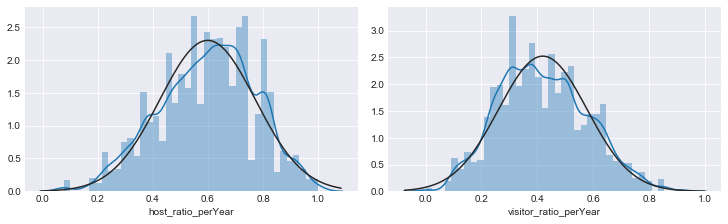

In [100]:
names = list(num_columns)
fig, axes = plt.subplots(1, 2, constrained_layout=True, figsize=(10,3))

for i,t in enumerate(names):
    sns.distplot(train_X[t], fit=norm, bins=40, ax=axes[i % 2])
pass;

In [101]:
transformed_k2, transformed_p = normaltest(train_X[names])
transformed_p

array([4.55456503e-39, 3.82647465e-40])

In [102]:
train_X.host_ratio_perYear.max(), train_X.visitor_ratio_perYear.max()

(1.00108, 0.92361)

In [103]:
mms = MinMaxScaler()
mms.fit(train_X[num_columns])
train_X[num_columns] = mms.transform(train_X[num_columns])

MinMaxScaler(copy=True, feature_range=(0, 1))

In [104]:
train_X.host_ratio_perYear.max(), train_X.visitor_ratio_perYear.max()

(1.0, 1.0)

Распределение ничем не отнормировалось, `MinMaxScaler` применен для ограничения диапазона числовых переменных (от 0 до 1).

In [105]:
train_X_cat = pd.get_dummies(train_X[cat_columns])
train_X_num = train_X[num_columns]

In [106]:
X_train = pd.concat((train_X_cat, train_X_num), axis=1)

In [107]:
X_train

,host_Атланта Хоукс,host_Бостон Селтикс,host_Бруклин Нетс,host_Вашингтон Уизардс,host_Голден Стэйт Уорриорз,host_Даллас Маверикс,host_Денвер Наггетс,host_Детройт Пистонс,host_Индиана Пэйсерс,host_Кливленд Кавальерс,host_Лос-Анджелес Клипперс,host_Лос-Анджелес Лейкерс,host_Майами Хит,host_Мемфис Гриззлиз,host_Милуоки Бакс,host_Миннесота Тимбервулвз,host_Нью-Йорк Никс,host_Нью-Орлеан Пеликанс,host_Оклахома-Сити Тандер,host_Орландо Мэджик,host_Портленд Трэйл Блэйзерс,host_Сакраменто Кингз,host_Сан-Антонио Спёрс,host_Торонто Рэпторс,host_Филадельфия Сиксерс,host_Финикс Санз,host_Хьюстон Рокетс,host_Чикаго Буллз,host_Шарлотт Хорнетс,host_Юта Джаз,visitor_Атланта Хоукс,visitor_Бостон Селтикс,visitor_Бруклин Нетс,visitor_Вашингтон Уизардс,visitor_Голден Стэйт Уорриорз,visitor_Даллас Маверикс,visitor_Денвер Наггетс,visitor_Детройт Пистонс,visitor_Индиана Пэйсерс,visitor_Кливленд Кавальерс,visitor_Лос-Анджелес Клипперс,visitor_Лос-Анджелес Лейкерс,visitor_Майами Хит,visitor_Мемфис Гриззлиз,visitor_Милуоки Бакс,visitor_Миннесота Тимбервулвз,visitor_Нью-Йорк Никс,visitor_Нью-Орлеан Пеликанс,visitor_Оклахома-Сити Тандер,visitor_Орландо Мэджик,visitor_Портленд Трэйл Блэйзерс,visitor_Сакраменто Кингз,visitor_Сан-Антонио Спёрс,visitor_Торонто Рэпторс,visitor_Филадельфия Сиксерс,visitor_Финикс Санз,visitor_Хьюстон Рокетс,visitor_Чикаго Буллз,visitor_Шарлотт Хорнетс,visitor_Юта Джаз,host_ratio_perYear,visitor_ratio_perYear
0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.317618,0.233053
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.595959,0.332012
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.603728,0.635333
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.815809,0.330226
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.649943,0.917584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10136,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.610492,0.591267
10137,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.516603,0.332012
10138,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.618434,0.320113
10139,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.370598,0.655244


**Подготовка тестовой выборки**

In [108]:
index_1 = test_df.index
test_s = shuffle(test_df, random_state=0)
test_s.index = index_1

In [109]:
test_X = test_s.drop('home_win', axis=1)
y_test = test_s.home_win

Y_test = label_encoder.fit_transform(y_test)
Y_test.shape

(688,)

In [110]:
test_X[num_columns] = mms.transform(test_X[num_columns])

In [111]:
test_X_cat = pd.get_dummies(test_X[cat_columns])
test_X_num = test_X[num_columns]

In [112]:
X_test = pd.concat((test_X_cat, test_X_num), axis=1)

In [113]:
X_test

,host_Атланта Хоукс,host_Бостон Селтикс,host_Бруклин Нетс,host_Вашингтон Уизардс,host_Голден Стэйт Уорриорз,host_Даллас Маверикс,host_Денвер Наггетс,host_Детройт Пистонс,host_Индиана Пэйсерс,host_Кливленд Кавальерс,host_Лос-Анджелес Клипперс,host_Лос-Анджелес Лейкерс,host_Майами Хит,host_Мемфис Гриззлиз,host_Милуоки Бакс,host_Миннесота Тимбервулвз,host_Нью-Йорк Никс,host_Нью-Орлеан Пеликанс,host_Оклахома-Сити Тандер,host_Орландо Мэджик,host_Портленд Трэйл Блэйзерс,host_Сакраменто Кингз,host_Сан-Антонио Спёрс,host_Торонто Рэпторс,host_Филадельфия Сиксерс,host_Финикс Санз,host_Хьюстон Рокетс,host_Чикаго Буллз,host_Шарлотт Хорнетс,host_Юта Джаз,visitor_Атланта Хоукс,visitor_Бостон Селтикс,visitor_Бруклин Нетс,visitor_Вашингтон Уизардс,visitor_Голден Стэйт Уорриорз,visitor_Даллас Маверикс,visitor_Денвер Наггетс,visitor_Детройт Пистонс,visitor_Индиана Пэйсерс,visitor_Кливленд Кавальерс,visitor_Лос-Анджелес Клипперс,visitor_Лос-Анджелес Лейкерс,visitor_Майами Хит,visitor_Мемфис Гриззлиз,visitor_Милуоки Бакс,visitor_Миннесота Тимбервулвз,visitor_Нью-Йорк Никс,visitor_Нью-Орлеан Пеликанс,visitor_Оклахома-Сити Тандер,visitor_Орландо Мэджик,visitor_Портленд Трэйл Блэйзерс,visitor_Сакраменто Кингз,visitor_Сан-Антонио Спёрс,visitor_Торонто Рэпторс,visitor_Филадельфия Сиксерс,visitor_Финикс Санз,visitor_Хьюстон Рокетс,visitor_Чикаго Буллз,visitor_Шарлотт Хорнетс,visitor_Юта Джаз,host_ratio_perYear,visitor_ratio_perYear
10141,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.671695,0.351317
10142,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.735383,0.629043
10143,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.733092,0.623034
10144,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.175082,0.496432
10145,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.191917,0.371954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10824,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.648960,0.502008
10825,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.638479,0.506437
10826,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.671695,0.319312
10827,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.639516,0.506437


### Моделирование

In [172]:
early_stop = EarlyStopping('val_accuracy', patience=30, verbose=1)

reduce_lr = ReduceLROnPlateau(
    factor=0.1, patience=3, min_lr=0.00001, verbose=1)

In [116]:
model_checkpoint_s = ModelCheckpoint(
    'models_1/base_model_s.h5', 'val_accuracy', save_best_only=True, verbose=1)

In [117]:
calls = [early_stop, reduce_lr, model_checkpoint_s]

In [122]:
def create_base():    
    model = Sequential()
    model.add(Dense(64, input_dim=62, kernel_initializer='he_uniform', 
                    kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(Dropout(.1))
    model.add(Dense(128, kernel_initializer='he_uniform', 
                    kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(Dropout(.1))
    model.add(Dense(256, kernel_initializer='he_uniform', 
                    kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(Dropout(.1))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=.01), metrics=['accuracy'])
    
    return model

In [127]:
base_model = create_base()

In [128]:
base_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                4032      
_________________________________________________________________
batch_normalization_4 (Batch (None, 64)                256       
_________________________________________________________________
activation_4 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               8320      
_________________________________________________________________
batch_normalization_5 (Batch (None, 128)               512       
_________________________________________________________________
activation_5 (Activation)    (None, 128)              

In [173]:
batch_size = 32
epochs = 80

In [130]:
history = base_model.fit(
    X_train,
    Y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_split=.1,
    callbacks=calls)

Instructions for updating:
Use tf.cast instead.
Train on 9126 samples, validate on 1015 samples
Epoch 1/80
9126/9126 [==============================] - 1s 117us/step - loss: 0.7211 - accuracy: 0.6586 - val_loss: 0.6708 - val_accuracy: 0.6719

Epoch 00001: val_accuracy improved from -inf to 0.67192, saving model to models_1/base_model_s.h5
Epoch 2/80
9126/9126 [==============================] - 1s 59us/step - loss: 0.6452 - accuracy: 0.6822 - val_loss: 0.6232 - val_accuracy: 0.6788

Epoch 00002: val_accuracy improved from 0.67192 to 0.67882, saving model to models_1/base_model_s.h5
Epoch 3/80
9126/9126 [==============================] - 1s 61us/step - loss: 0.6109 - accuracy: 0.6881 - val_loss: 0.6044 - val_accuracy: 0.6867

Epoch 00003: val_accuracy improved from 0.67882 to 0.68670, saving model to models_1/base_model_s.h5
Epoch 4/80
9126/9126 [==============================] - 1s 61us/step - loss: 0.6027 - accuracy: 0.6947 - val_loss: 0.5958 - val_accuracy: 0.6906

Epoch 00004: val_ac


Epoch 00037: val_accuracy did not improve from 0.70246
Epoch 38/80
9126/9126 [==============================] - 1s 57us/step - loss: 0.5753 - accuracy: 0.7051 - val_loss: 0.5861 - val_accuracy: 0.6877

Epoch 00038: val_accuracy did not improve from 0.70246
Epoch 39/80
9126/9126 [==============================] - 1s 58us/step - loss: 0.5729 - accuracy: 0.7056 - val_loss: 0.5861 - val_accuracy: 0.6887

Epoch 00039: val_accuracy did not improve from 0.70246
Epoch 40/80
9126/9126 [==============================] - 1s 57us/step - loss: 0.5716 - accuracy: 0.7093 - val_loss: 0.5860 - val_accuracy: 0.6847

Epoch 00040: val_accuracy did not improve from 0.70246
Epoch 41/80
9126/9126 [==============================] - 1s 56us/step - loss: 0.5742 - accuracy: 0.7069 - val_loss: 0.5860 - val_accuracy: 0.6867

Epoch 00041: val_accuracy did not improve from 0.70246
Epoch 42/80
9126/9126 [==============================] - 1s 56us/step - loss: 0.5733 - accuracy: 0.7006 - val_loss: 0.5861 - val_accurac

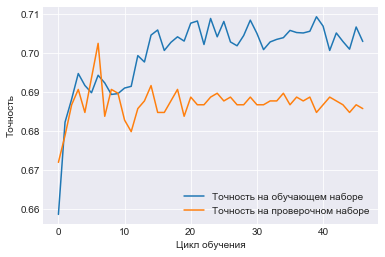

In [131]:
plt.plot(
    history.history['accuracy'], label='Точность на обучающем наборе')
plt.plot(
    history.history['val_accuracy'],
    label='Точность на проверочном наборе')
plt.xlabel('Цикл обучения')
plt.ylabel('Точность')
plt.legend()
plt.show()
pass;

In [141]:
score_base = base_model.evaluate(X_test, Y_test, verbose=0)
print("\nTest score:", round(score_base[0], 3))
print('Test accuracy:', round(score_base[1], 3))


Test score: 0.628
Test accuracy: 0.67


In [133]:
pred_y = base_model.predict(X_test, verbose=0)
pred_y[:5]

array([[0.83749056],
       [0.6111658 ],
       [0.63605314],
       [0.19278476],
       [0.36594814]], dtype=float32)

Вычисляем оптимальный порог отнесения к значениям целевой переменной.

In [136]:
y_pred = base_model.predict(X_test)[:, 0]
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))

Best Threshold=0.661360


In [137]:
y_test_pred = [1 if x > best_thresh else 0 for x in y_pred]

In [138]:
print(classification_report(y_test_pred, Y_test))

              precision    recall  f1-score   support

           0       0.73      0.57      0.64       370
           1       0.60      0.76      0.67       318

    accuracy                           0.66       688
   macro avg       0.67      0.67      0.66       688
weighted avg       0.67      0.66      0.66       688



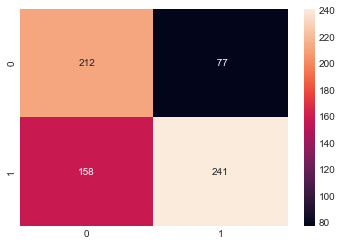

In [139]:
sns.heatmap(confusion_matrix(Y_test, y_test_pred), annot=True, fmt='3.0f');